In [5]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import yfinance as yf
import matplotlib.pyplot as plt

# Step 1: Fetch and preprocess data
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data.columns = data.columns.get_level_values(0)  # Flatten columns
    data['Returns'] = data['Close'].pct_change()
    data['Log Returns'] = np.log(1 + data['Returns'])
    return data.dropna()

# Step 2: Prepare features
def prepare_features(data):
    data['Volatility'] = data['Log Returns'].rolling(window=5).std()
    features = data[['Log Returns', 'Volatility']].dropna().values  # 2D array
    aligned_data = data.dropna(subset=['Log Returns', 'Volatility'])  # Align with features
    return aligned_data, features

# Step 3: Train HMM
def train_hmm(features, n_states):
    print("Training HMM with features shape:", features.shape)  # Debugging
    model = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=1000, random_state=42)
    model.fit(features)
    hidden_states = model.predict(features)
    return model, hidden_states

def plot_hidden_states(data, hidden_states, n_states):
    plt.figure(figsize=(15, 8))
    for state in range(n_states):
        state_data = data[hidden_states == state]
        plt.plot(state_data.index, state_data['Close'], '.', label=f"State {state}")
    plt.title("Stock Price by Hidden States")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()

def simulate_trading(data, hidden_states):
    data['State'] = hidden_states
    data['Signal'] = data['State'].apply(lambda x: 1 if x == 0 else -1)  # Buy in state 0, sell in others
    data['Strategy Returns'] = data['Signal'].shift(1) * data['Returns']
    cumulative_strategy_returns = (1 + data['Strategy Returns'].dropna()).cumprod()
    cumulative_market_returns = (1 + data['Returns'].dropna()).cumprod()
    
    plt.figure(figsize=(15, 8))
    plt.plot(cumulative_strategy_returns, label="Strategy Returns")
    plt.plot(cumulative_market_returns, label="Market Returns")
    plt.legend()
    plt.title("Trading Strategy vs. Market")
    plt.show()


[*********************100%***********************]  1 of 1 completed

Training HMM with features shape: (2259, 2)
Hidden states shape: (2259,)


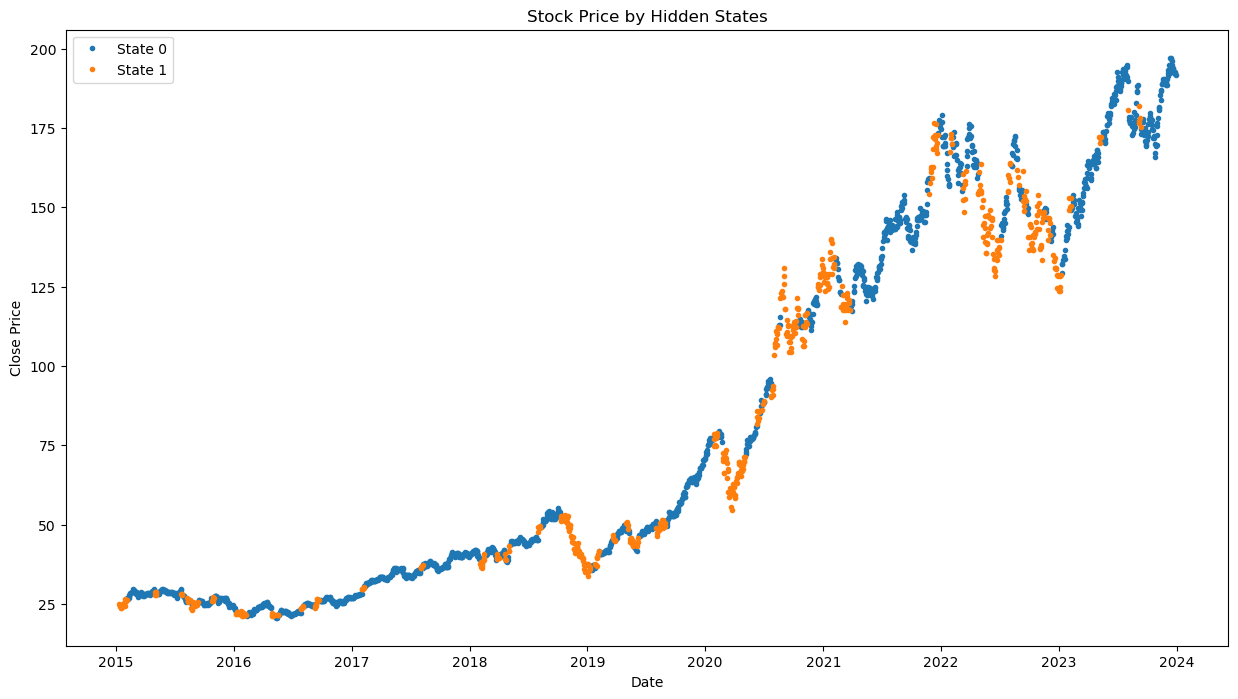

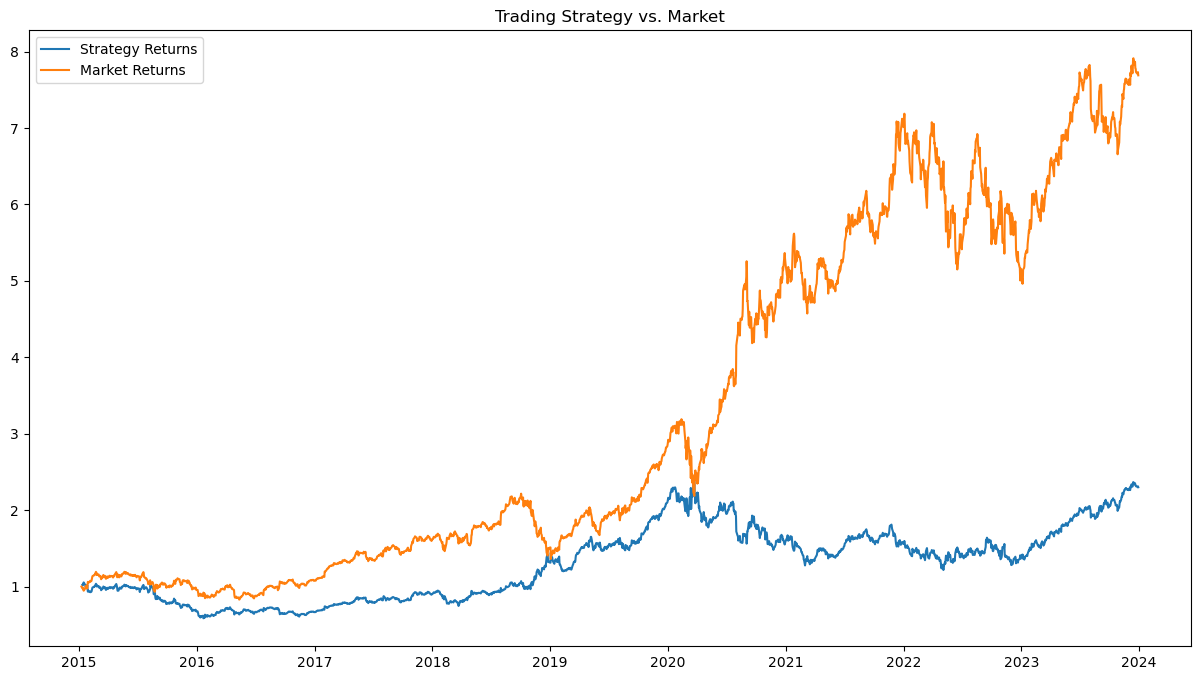

In [7]:
ticker = "AAPL"
start_date = "2015-01-01"
end_date = "2023-12-31"

# Fetch and preprocess data
stock_data = fetch_stock_data(ticker, start_date, end_date)

# Prepare features
aligned_data, features = prepare_features(stock_data)

# Train HMM
n_states = 2
hmm_model, hidden_states = train_hmm(features, n_states)

print("Hidden states shape:", hidden_states.shape)  # Should be (2259,)
# Plot Hidden States 
aligned_data = aligned_data.copy()  # Ensure it's a standalone DataFrame
aligned_data['State'] = hidden_states
aligned_data['Signal'] = aligned_data['State'].apply(lambda x: 1 if x == 0 else -1)  # Buy in state 0, sell in others
aligned_data['Strategy Returns'] = aligned_data['Signal'].shift(1) * aligned_data['Returns']
    
plot_hidden_states(aligned_data, hidden_states, n_states)

# Simulate Trading Strategy 
simulate_trading(aligned_data, hidden_states)
